**Waze’s free navigation app makes it easier for drivers around the world to get to where they want to go. Waze’s community of map editors, beta testers, translators, partners, and users helps make each drive better and safer. Waze partners with cities, transportation authorities, broadcasters, businesses, and first responders to help as many people as possible travel more efficiently and safely.**

**The team is about to start a new project to help prevent user churn on the Waze app. Churn quantifies the number of users who have uninstalled the Waze app or stopped using the app. This project focuses on monthly user churn.**

**This project is part of a larger effort at Waze to increase growth. Typically, high retention rates indicate satisfied users who repeatedly use the Waze app over time. Developing a churn prediction model will help prevent churn, improve user retention, and grow Waze’s business. An accurate model can also help identify specific factors that contribute to churn and answer questions such as:**

**Who are the users most likely to churn?**

**Why do users churn?**

**When do users churn?**

**For example, if Waze can identify a segment of users who are at high risk of churning, Waze can proactively engage these users with special offers to try and retain them. Otherwise, Waze may simply lose these users without knowing why.**

In [34]:
# Import packages for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import  RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [32]:
df.size

224985

In [2]:
# Load dataset into dataframe
df = pd.read_csv(r'C:/Users/ACER/Downloads/archive (18)/waze_dataset.csv')

In [18]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


**Discovery**: There are some missing value in the column label

In [20]:
# Isolate rows with null values
null_df = df[df['label'].isnull()]
# Display summary stats of rows with null values
null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [21]:
# Isolate rows without null values
not_null_df = df[~df['label'].isnull()]
# Display summary stats of rows without null values
not_null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


**Discovery**: Comparing summary statistics of the observations with missing retention labels with those that aren't missing any values reveals nothing remarkable. The means and standard deviations are fairly consistent between the two groups.

Devices of the missing labels

In [22]:
null_df['device'].value_counts()

iPhone     447
Android    253
Name: device, dtype: int64

In [23]:
# Calculate % of iPhone nulls and Android nulls
null_df['device'].value_counts(normalize=True)

iPhone     0.638571
Android    0.361429
Name: device, dtype: float64

In [24]:
# Calculate % of iPhone users and Android users in full dataset
df['device'].value_counts(normalize=True)

iPhone     0.644843
Android    0.355157
Name: device, dtype: float64

**Discovery**: The percentage of missing values by each device is consistent with their representation in the data overall.

There is nothing to suggest a non-random cause of the missing data

In [25]:
# Calculate counts of churned vs. retained
print(df['label'].value_counts())
print()
print(df['label'].value_counts(normalize=True))

retained    11763
churned      2536
Name: label, dtype: int64

retained    0.822645
churned     0.177355
Name: label, dtype: float64


**Discovery**: This dataset contains 82% retained users and 18% churned users.

In [26]:
# Calculate median values of all columns for churned and retained users
df.groupby('label').median(numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


**Discover**: This offers an interesting snapshot of the two groups, churned vs. retained:

Users who churned averaged ~3 more drives in the last month than retained users, but retained users used the app on over twice as many days as churned users in the same time period.

The median churned user drove ~200 more kilometers and 2.5 more hours during the last month than the median retained user.

It seems that churned users had more drives in fewer days, and their trips were farther and longer in duration. Perhaps this is suggestive of a user profile.Let's continue exploring!

In [27]:
# Add a column to df called `km_per_drive`
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Group by `label`, calculate the median, and isolate for km per drive
median_km_per_drive = df.groupby('label').median(numeric_only=True)[['km_per_drive']]
median_km_per_drive

,km_per_drive
label,
churned,74.109416
retained,75.014702


The median retained user drove about one more kilometer per drive than the median churned user. How many kilometers per driving day was this?

In [28]:
# Add a column to df called `drives_per_driving_day`
df['drives_per_driving_day'] = df['drives'] / df['driving_days']

# Group by `label`, calculate the median, and isolate for drives per driving day
median_drives_per_driving_day = df.groupby('label').median(numeric_only=True)[['drives_per_driving_day']]
median_drives_per_driving_day

,drives_per_driving_day
label,
churned,10.0000
retained,4.0625


In [29]:
# For each label, calculate the number of Android users and iPhone users
df.groupby(['label', 'device']).size()

label     device 
churned   Android     891
          iPhone     1645
retained  Android    4183
          iPhone     7580
dtype: int64

In [30]:
# For each label, calculate the percentage of Android users and iPhone users
df.groupby('label')['device'].value_counts(normalize=True)

label     device 
churned   iPhone     0.648659
          Android    0.351341
retained  iPhone     0.644393
          Android    0.355607
Name: device, dtype: float64

The ratio of iPhone users and Android users is consistent between the churned group and the retained group, and those ratios are both consistent with the ratio found in the overall dataset.

**Why is a benefit of using the median value of a sample instead of the mean?**
Mean is subject to the influence of outliers, while the median represents the middle value of the distribution regardless of any outlying values.

Generally, users who churned drove farther and longer in fewer days than retained users. They also used the app about half as many times as retained users over the same period.

The churn rate for both iPhone and Android users was within one percentage point of each other. There is nothing suggestive of churn being correlated with device.

#### Exploration Through Visualization

*     Box plots will be helpful to determine outliers and where the bulk of the data points reside in terms of `drives`, `sessions` and all other continuous numeric variables
*     Histograms are essential to understand the distribution of variables
*     Scatter plots will be helpful to visualize relationships between variables
*     Bar charts are useful for communicating levels and quantities, especially for categorical information


#### **`sessions`**

_The number of occurrences of a user opening the app during the month_

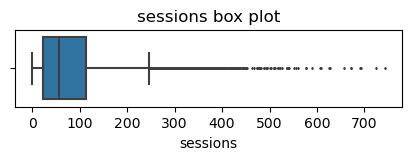

In [33]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('sessions box plot');

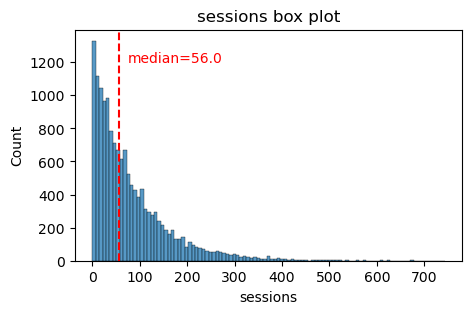

In [34]:
# Histogram
plt.figure(figsize=(5,3))
sns.histplot(x=df['sessions'])
median = df['sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1200, 'median=56.0', color='red')
plt.title('sessions box plot');

The sessions variable is a right-skewed distribution with half of the observations having 56 or fewer sessions. However, as indicated by the boxplot, some users have more than 700.

#### **drives**
An occurrence of driving at least 1 km during the month

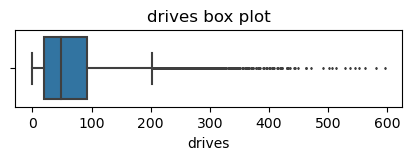

In [35]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['drives'], fliersize=1)
plt.title('drives box plot');

In [36]:
# Helper function to plot histograms based on the
# format of the `sessions` histogram
def histogrammer(column_str, median_text=True, **kwargs):    # **kwargs = any keyword arguments
                                                             # from the sns.histplot() function
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df[column_str], **kwargs)            # Plot the histogram
    plt.axvline(median, color='red', linestyle='--')         # Plot the median line
    if median_text==True:                                    # Add median text unless set to False
        ax.text(0.25, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');

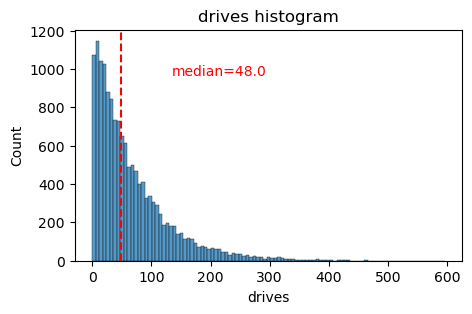

In [37]:
# Histogram
histogrammer('drives')

The drives information follows a distribution similar to the sessions variable. It is right-skewed, approximately log-normal, with a median of 48. However, some drivers had over 400 drives in the last month.

#### **`total_sessions`**
A model estimate of the total number of sessions since a user has onboarded

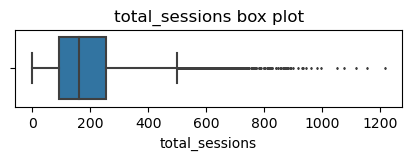

In [38]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['total_sessions'], fliersize=1)
plt.title('total_sessions box plot');

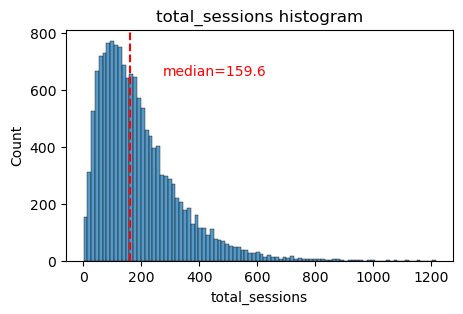

In [39]:
# Histogram
histogrammer('total_sessions')

The total_sessions is a right-skewed distribution. The median total number of sessions is 159.6. This is interesting information because, if the median number of sessions in the last month was 56 and the median total sessions was ~160, then it seems that a large proportion of a user's (estimated) total drives might have taken place in the last month. This is something you can examine more closely later.

#### **`n_days_after_onboarding`**
The number of days since a user signed up for the app

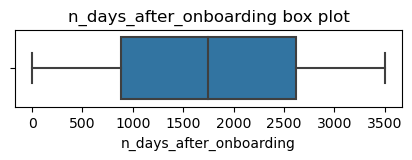

In [40]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['n_days_after_onboarding'], fliersize=1)
plt.title('n_days_after_onboarding box plot');

Median: 1741.0


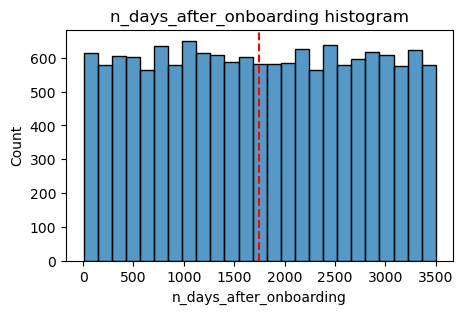

In [41]:
# Histogram
histogrammer('n_days_after_onboarding', median_text=False)

The total user tenure (i.e., number of days since
onboarding) is a uniform distribution with values ranging from near-zero to \~3,500 (\~9.5 years).

#### **`driven_km_drives`**
Total kilometers driven during the month

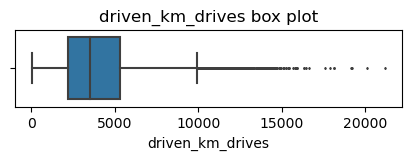

In [43]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driven_km_drives'], fliersize=1)
plt.title('driven_km_drives box plot');

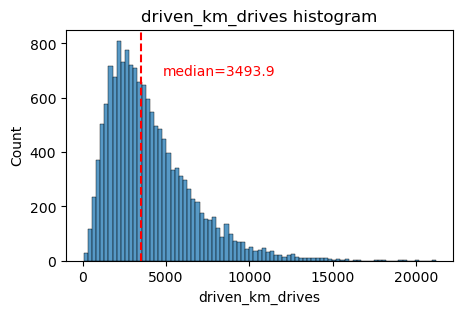

In [44]:
# Histogram
histogrammer('driven_km_drives')

The number of drives driven in the last month per user is a right-skewed distribution with half the users driving under 3,495 kilometers. As you discovered in the analysis from the previous course, the users in this dataset drive a lot. The longest distance driven in the month was over half the circumferene of the earth.

#### **duration_minutes_drives**
Total duration driven in minutes during the month

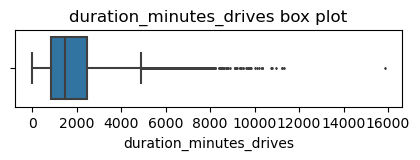

In [45]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['duration_minutes_drives'], fliersize=1)
plt.title('duration_minutes_drives box plot');

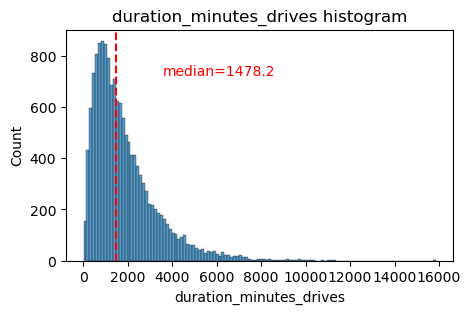

In [46]:
# Histogram
histogrammer('duration_minutes_drives')


The duration_minutes_drives variable has a heavily skewed right tail. Half of the users drove less than ~1,478 minutes (~25 hours), but some users clocked over 250 hours over the month.

#### **`activity_days`**
Number of days the user opens the app during the month

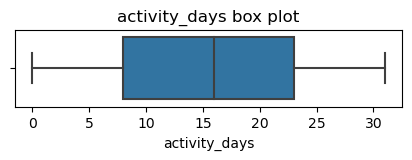

In [47]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['activity_days'], fliersize=1)
plt.title('activity_days box plot');

Median: 16.0


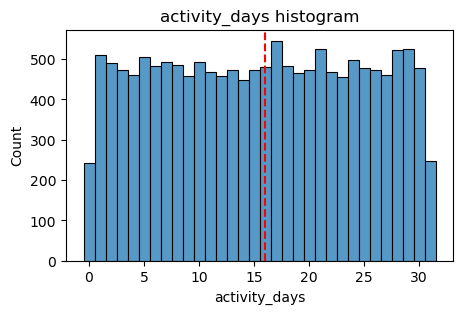

In [48]:
# Histogram
histogrammer('activity_days', median_text=False, discrete=True)

Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 people opening the app on each count of days. However, there are ~250 people who didn't open the app at all and ~250 people who opened the app every day of the month.

This distribution is noteworthy because it does not mirror the sessions distribution, which you might think would be closely correlated with activity_days

#### **`driving_days`**
Number of days the user drives (at least 1 km) during the month

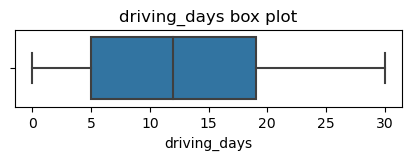

In [49]:
# Box plot
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driving_days'], fliersize=1)
plt.title('driving_days box plot');

Median: 12.0


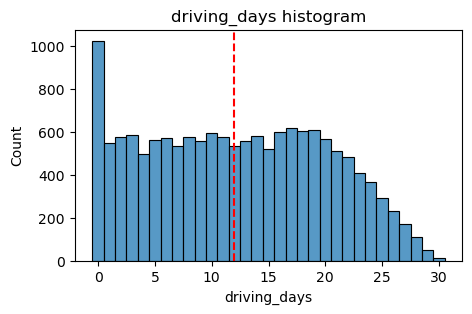

In [50]:
# Histogram
histogrammer('driving_days', median_text=False, discrete=True)

The number of days users drove each month is almost uniform, and it largely correlates with the number of days they opened the app that month, except the driving_days distribution tails off on the right.

However, there were almost twice as many users (~1,000 vs. ~550) who did not drive at all during the month. This might seem counterintuitive when considered together with the information from activity_days. That variable had ~500 users opening the app on each of most of the day counts, but there were only ~250 users who did not open the app at all during the month and ~250 users who opened the app every day. Flag this for further investigation later.

#### **`device`**
The type of device a user starts a session with

This is a categorical variable, so you do not plot a box plot for it. A good plot for a binary categorical variable is a pie chart.

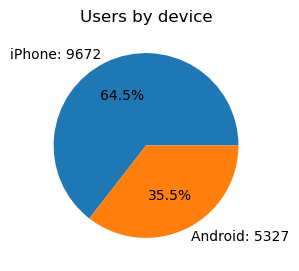

In [51]:
# Pie chart
fig = plt.figure(figsize=(3,3))
data=df['device'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Users by device');

#### label
Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month

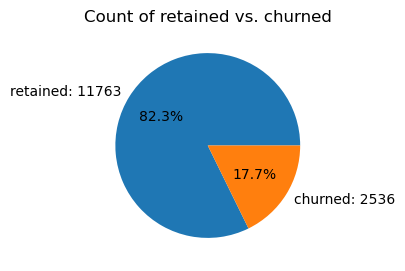

In [52]:
# Pie chart
fig = plt.figure(figsize=(3,3))
data=df['label'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Count of retained vs. churned');

#### driving_days vs. activity_days
Because both driving_days and activity_days represent counts of days over a month and they're also closely related, you can plot them together on a single histogram. This will help to better understand how they relate to each other without having to scroll back and forth comparing histograms in two different places.

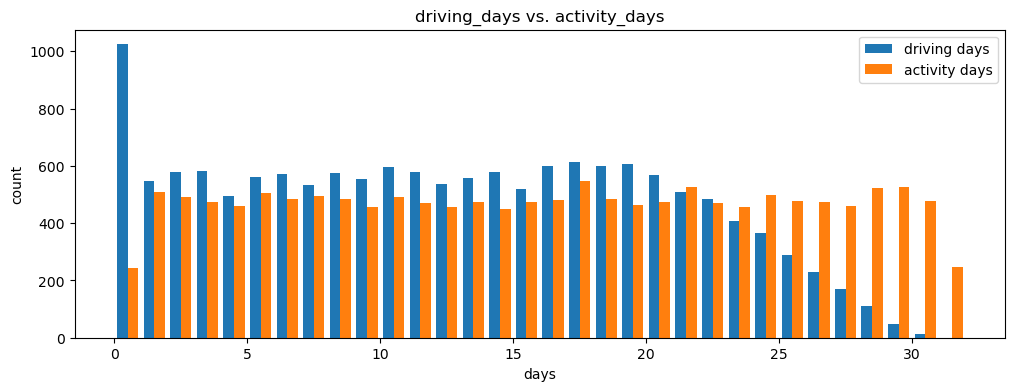

In [54]:
# Histogram
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

As observed previously, this might seem counterintuitive. After all, why are there fewer people who didn't use the app at all during the month and more people who didn't drive at all during the month?

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive—perhaps to check drive times or route information, to update settings, or even just by mistake.

In [55]:
print(df['driving_days'].max())
print(df['activity_days'].max())

30
31


One other way to check the validity of these variables is to plot a simple scatter plot with the x-axis representing one variable and the y-axis representing the other.



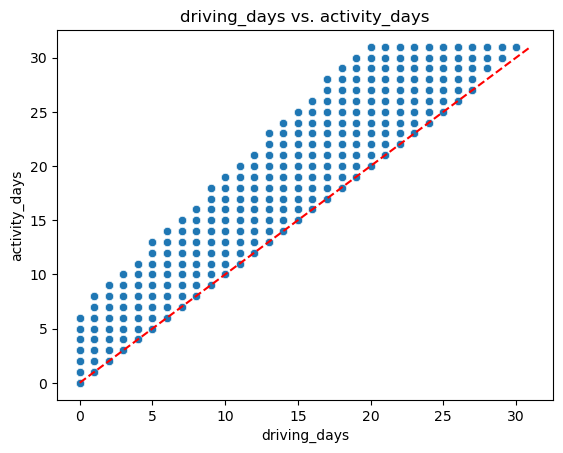

In [57]:
# Scatter plot
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

Notice that there is a theoretical limit. If you use the app to drive, then by definition it must count as a day-use as well. In other words, you cannot have more drive-days than activity-days. None of the samples in this data violate this rule, which is good.

#### Retention by device
Plot a histogram that has four bars—one for each device-label combination—to show how many iPhone users were retained/churned and how many Android users were retained/churned.

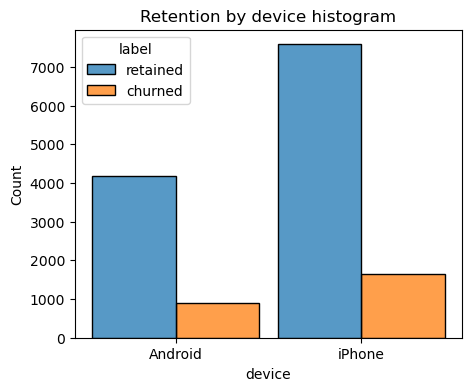

In [58]:
# Histogram
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

In [59]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

The mean value is infinity, the standard deviation is NaN, and the max value is infinity. Why do you think this is?

This is the result of there being values of zero in the driving_days column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

In [60]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

The maximum value is 15,420 kilometers per drive day. This is physically impossible. Driving 100 km/hour for 12 hours is 1,200 km. It's unlikely many people averaged more than this each day they drove, so, for now, disregard rows where the distance in this column is greater than 1,200 km

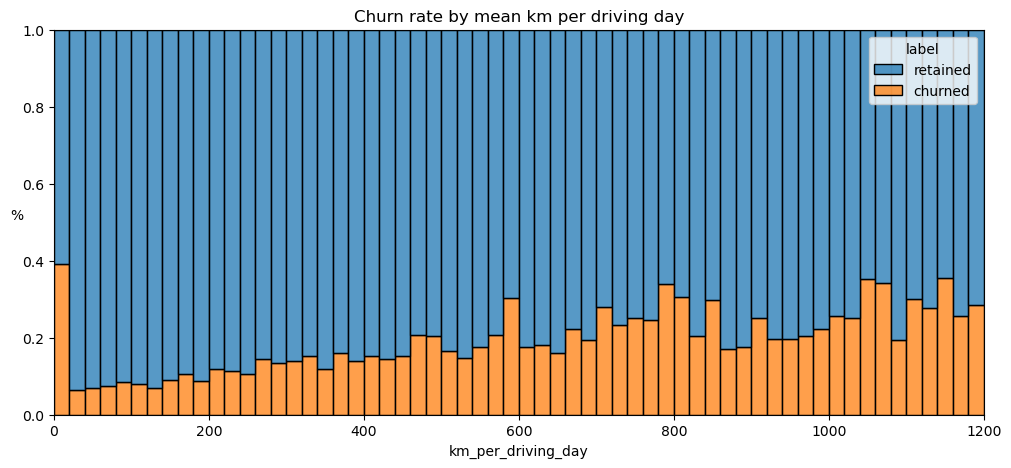

In [61]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn rate by mean km per driving day');

The churn rate tends to increase as the mean daily distance driven increases

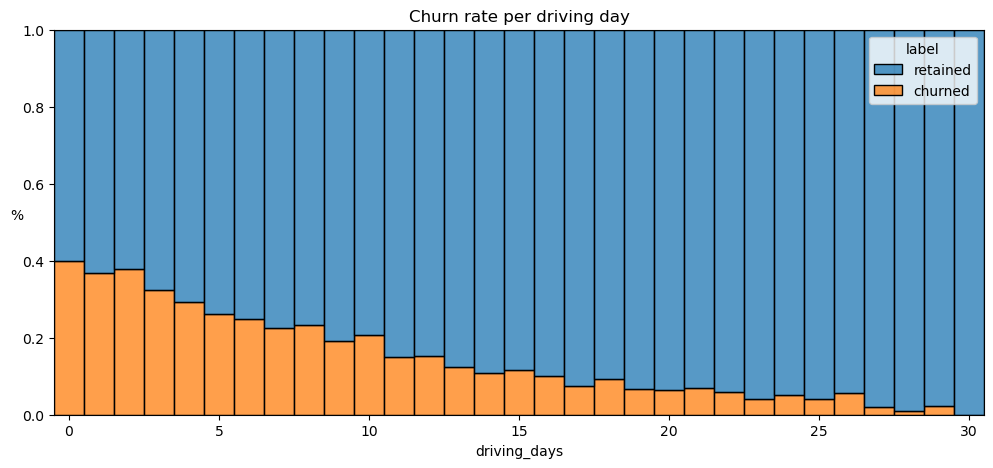

In [62]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app. Maybe they moved to a city with good public transportation and don't need to drive anymore.

In [63]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

In [64]:
df['percent_sessions_in_last_month'].median()

0.42309702992763176

Median: 0.4


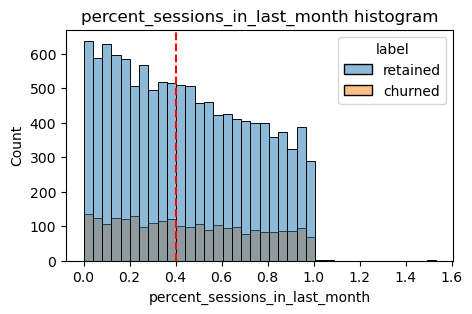

In [65]:
# Histogram
histogrammer('percent_sessions_in_last_month',
             hue=df['label'],
             multiple='layer',
             median_text=False)

In [66]:
df['n_days_after_onboarding'].median()

1741.0

Half of the people in the dataset had 40% or more of their sessions in just the last month, yet the overall median time since onboarding is almost five years.

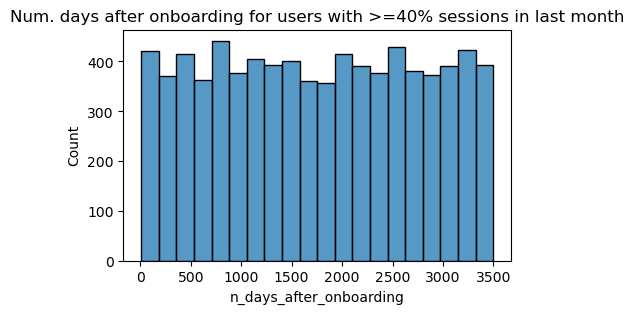

In [67]:
# Histogram
data = df.loc[df['percent_sessions_in_last_month']>=0.4]
plt.figure(figsize=(5,3))
sns.histplot(x=data['n_days_after_onboarding'])
plt.title('Num. days after onboarding for users with >=40% sessions in last month');

The number of days since onboarding for users with 40% or more of their total sessions occurring in just the last month is a uniform distribution.

#### Handling outliers
The box plots from the previous section indicated that many of these variables have outliers. These outliers do not seem to be data entry errors; they are present because of the right-skewed distributions.

Depending on what you'll be doing with this data, it may be useful to impute outlying data with more reasonable values. One way of performing this imputation is to set a threshold based on a percentile of the distribution.

In [68]:
def outlier_imputer(column_name, percentile):
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)
    # Impute threshold for values > than threshold
    df.loc[df[column_name] > threshold, column_name] = threshold

    print('{:>25} | percentile: {} | threshold: {}'.format(column_name, percentile, threshold))

In [69]:
for column in ['sessions', 'drives', 'total_sessions',
               'driven_km_drives', 'duration_minutes_drives']:
               outlier_imputer(column, 0.95)

                 sessions | percentile: 0.95 | threshold: 243.0
                   drives | percentile: 0.95 | threshold: 201.0
           total_sessions | percentile: 0.95 | threshold: 454.3632037399997
         driven_km_drives | percentile: 0.95 | threshold: 8889.7942356
  duration_minutes_drives | percentile: 0.95 | threshold: 4668.899348999998


In [70]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,drives_per_driving_day,km_per_driving_day,percent_sessions_in_last_month
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04,1.499200e+04,14999.000000,14999.000000
mean,7499.000000,76.568705,64.058204,184.031320,1749.837789,121.605974,29.672512,3939.632764,1789.647426,15.537102,12.179879,inf,inf,578.963113,0.449255
std,4329.982679,67.297958,55.306924,118.600463,1008.513876,148.121544,45.394651,2216.041510,1222.705167,9.004655,7.824036,NaN,NaN,1030.094384,0.286919
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,1.008775e+00,0.000000e+00,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,3.323065e+01,1.800000e+00,136.238895,0.196221
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,7.488006e+01,4.666667e+00,272.889272,0.423097
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,1.854667e+02,1.216667e+01,558.686918,0.687216
max,14998.000000,243.000000,201.000000,454.363204,3500.000000,1236.000000,415.000000,8889.794236,4668.899349,31.000000,30.000000,inf,inf,15420.234110,1.530637


In [71]:
df['monthly_drives_per_session_ratio'] = (df['drives']/df['sessions'])

In [72]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,drives_per_driving_day,km_per_driving_day,percent_sessions_in_last_month,monthly_drives_per_session_ratio
0,0,retained,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,11.632058,11.894737,138.360267,0.953670,0.827160
1,1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,128.186173,9.727273,1246.901868,0.406856,0.804511
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,32.201567,11.875000,382.393602,0.841186,0.833333
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,22.839778,13.333333,304.530374,0.724968,0.816327
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,58.091206,3.777778,219.455667,0.499266,0.809524
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,8.749890,9.363636,81.930791,0.404229,0.911504
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,2624.586414,0.086957,228.224906,0.012673,0.666667
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,225.487213,1.750000,394.602623,0.221499,0.897436
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,57.645864,2.300000,132.585488,0.310573,0.807018
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,88.874416,22.666667,2014.486765,0.343134,0.809524


In [73]:
# 1. Create `map_dictionary`
map_dictionary = {'Android': 2, 'iPhone': 1}

# 2. Create new `device_type` column
df['device_type'] = df['device']

# 3. Map the new column to the dictionary
df['device_type'] = df['device_type'].map(map_dictionary)

df['device_type'].head()

0    2
1    1
2    2
3    1
4    2
Name: device_type, dtype: int64

In [74]:
df.groupby('device_type')['drives'].mean()

device_type
1    64.446340
2    63.353482
Name: drives, dtype: float64

#### Hypothesis Testing

The goal is to conduct a two-sample t-test. The steps for conducting a hypothesis test:


1.   State the null hypothesis and the alternative hypothesis
2.   Choose a signficance level
3.   Find the p-value
4.   Reject or fail to reject the null hypothesis

**Note:** This is a t-test for two independent samples. This is the appropriate test since the two groups are independent (Android users vs. iPhone users).


**Hypotheses:**

$H_0$: There is no difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.

$H_A$: There is a difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.

In [75]:
# 1. Isolate the `drives` column for iPhone users.
iPhone = df[df['device_type'] == 1]['drives']

# 2. Isolate the `drives` column for Android users.
Android = df[df['device_type'] == 2]['drives']

# 3. Perform the t-test
stats.ttest_ind(a=iPhone, b=Android, equal_var=False)

Ttest_indResult(statistic=1.1643714136026293, pvalue=0.24429844267242223)

Since the p-value is larger than the chosen significance level (5%), you fail to reject the null hypothesis. You conclude that there is not a statistically significant difference in the average number of drives between drivers who use iPhones and drivers who use Androids.

The key business insight is that drivers who use iPhone devices on average have a similar number of drives as those who use Androids.

We will build a binomial logistic regression model.logistic regression helps us estimate the probability of an outcome. For data science professionals, this is a useful skill because it allows us to consider more than one variable against the variable we're measuring against. This opens the door for much more thorough and flexible analysis to be completed.

In [3]:
df = df.drop('ID', axis=1)

In [4]:
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [5]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [124]:
df.isna().sum()

label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

In [6]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [7]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [8]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [9]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

In [10]:
df = df.dropna(subset=['label'])

In [11]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [12]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


In [13]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [86]:
df.corr(method='pearson')

C:\Users\ACER\AppData\Local\Temp\ipykernel_8680\1928163937.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,drives_per_driving_day,km_per_driving_day,percent_sessions_in_last_month,monthly_drives_per_session_ratio,device_type,professional_driver,label2
sessions,1.000000,0.996942,0.597299,0.007101,0.001858,0.008536,0.002995,-0.004545,0.025113,0.020294,-0.321676,0.454513,-0.012541,0.614136,-0.356005,-0.012704,0.443654,0.034911
drives,0.996942,1.000000,0.595396,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.325440,0.455807,-0.011930,0.614282,-0.308124,-0.011684,0.444425,0.035865
total_sessions,0.597299,0.595396,1.000000,0.006615,0.000194,0.010363,0.001015,-0.000345,0.015757,0.012957,-0.194402,0.274758,-0.015712,-0.113455,-0.205398,-0.012133,0.254532,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006615,1.000000,-0.002450,-0.004968,-0.004655,-0.010167,-0.009418,-0.007321,0.004168,-0.002340,0.011042,-0.000874,0.000995,0.011299,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000194,-0.002450,1.000000,0.002866,-0.007365,0.005646,0.010902,0.010419,-0.005254,0.009056,0.000248,0.015180,-0.020639,0.001316,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010363,-0.004968,0.002866,1.000000,0.003567,-0.003009,-0.004425,0.002000,0.002902,0.002379,0.004987,0.000603,0.003043,0.000275,0.007126,0.015032
driven_km_drives,0.002995,0.003445,0.001015,-0.004655,-0.007365,0.003567,1.000000,0.690547,-0.007445,-0.009550,0.227341,0.013289,0.334570,-0.002088,0.000507,0.002086,-0.000901,0.019771
duration_minutes_drives,-0.004545,-0.003889,-0.000345,-0.010167,0.005646,-0.003009,0.690547,1.000000,-0.007895,-0.009425,0.170689,0.003930,0.233239,-0.007884,0.019937,0.007709,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015757,-0.009418,0.010902,-0.004425,-0.007445,-0.007895,1.000000,0.947687,-0.005588,-0.413663,-0.414920,0.017840,-0.019597,0.010221,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012957,-0.007321,0.010419,0.002000,-0.009550,-0.009425,0.947687,1.000000,-0.004337,-0.428643,-0.425030,0.013550,-0.016645,0.003859,0.469776,-0.294259


C:\Users\ACER\AppData\Local\Temp\ipykernel_8680\1955559285.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')


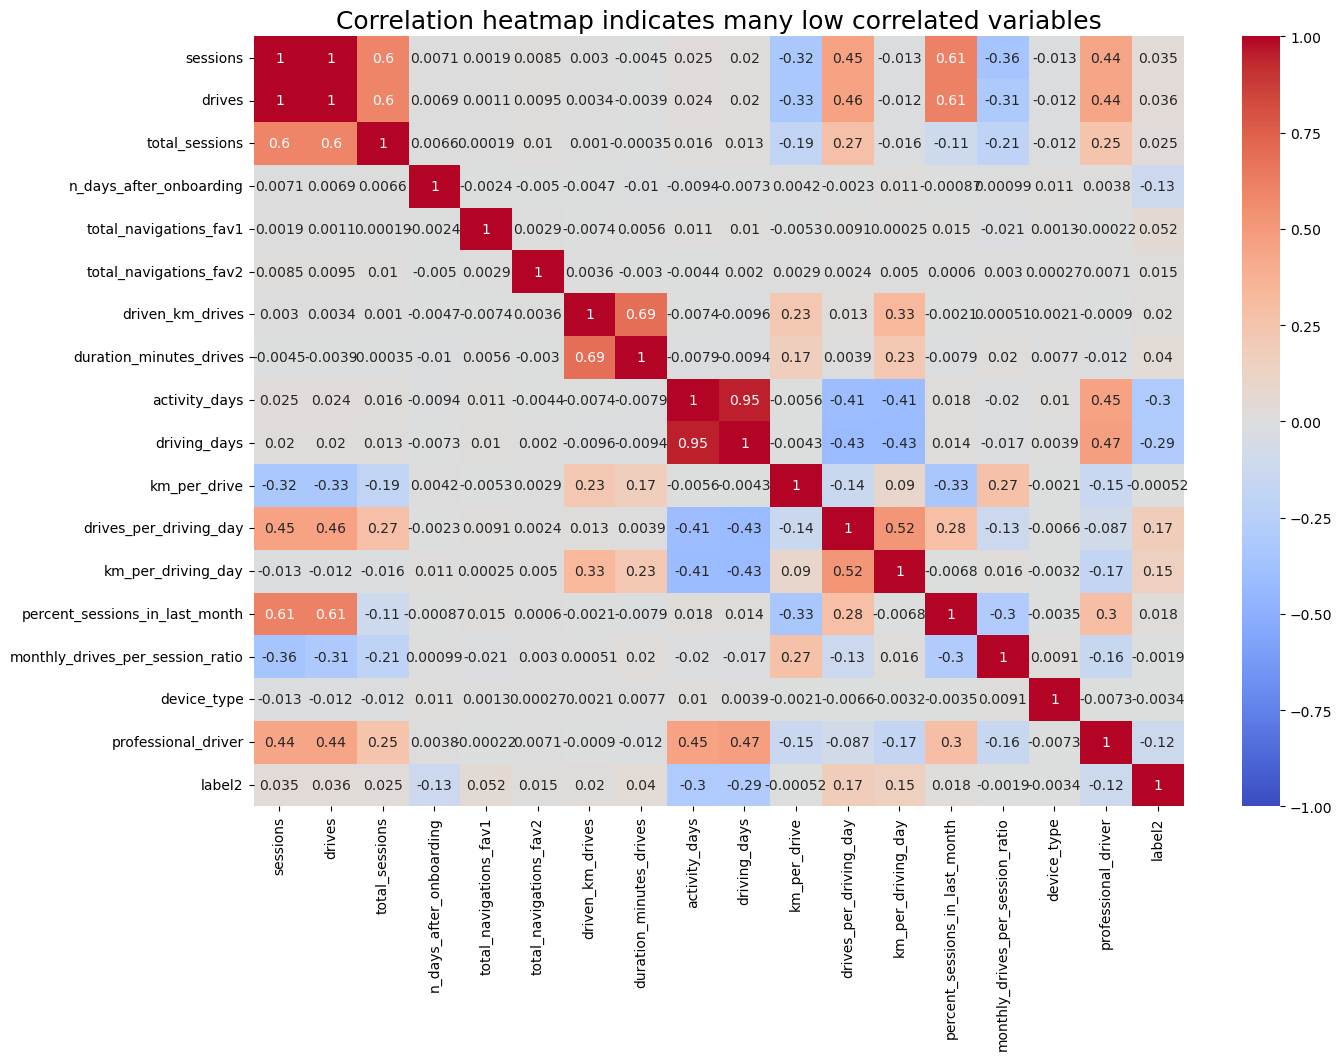

In [87]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

In [14]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [15]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [16]:
# Isolate target variable
y = df['label2']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [118]:
X_train.describe()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_drive,drives_per_driving_day,km_per_driving_day,percent_sessions_in_last_month,monthly_drives_per_session_ratio,device_type,professional_driver,device2
count,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.0,1.064300e+04,10643.0,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000
mean,64.483322,184.188179,1749.508879,114.585549,27.210279,3920.568562,1782.934164,15.541483,0.0,inf,0.0,0.451747,0.860716,1.350277,0.174199,0.649723
std,55.167037,118.511746,1011.054653,124.313847,36.688082,2207.597095,1218.234819,9.031562,0.0,NaN,0.0,0.284587,0.077564,0.477079,0.379298,0.477079
min,0.000000,2.894852,4.000000,0.000000,0.000000,159.444055,18.282082,0.000000,0.0,0.000000e+00,0.0,0.001229,0.000000,1.000000,0.000000,0.000000
25%,21.000000,91.126217,869.000000,10.000000,0.000000,2207.711591,837.498532,8.000000,0.0,1.846154e+00,0.0,0.201385,0.805195,1.000000,0.000000,0.000000
50%,49.000000,158.852137,1740.000000,72.000000,9.000000,3474.281033,1467.401184,16.000000,0.0,4.714286e+00,0.0,0.427314,0.826087,1.000000,0.000000,1.000000
75%,93.000000,253.911551,2630.000000,178.000000,43.000000,5260.068203,2452.110473,23.000000,0.0,1.242857e+01,0.0,0.686062,0.900000,2.000000,0.000000,1.000000
max,200.000000,454.363204,3500.000000,422.000000,124.000000,8889.794236,4668.116791,31.000000,0.0,inf,0.0,1.056036,1.000000,2.000000,1.000000,1.000000


In [19]:
model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)


C:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=400, penalty='none')

In [20]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001913
total_sessions             0.000327
n_days_after_onboarding   -0.000406
total_navigations_fav1     0.001232
total_navigations_fav2     0.000931
driven_km_drives          -0.000015
duration_minutes_drives    0.000109
activity_days             -0.106032
km_per_driving_day         0.000018
professional_driver       -0.001529
device2                   -0.001041
dtype: float64

In [21]:
model.intercept_

array([-0.00170675])

In [22]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963496, 0.06036504],
       [0.61967285, 0.38032715],
       [0.76463152, 0.23536848],
       ...,
       [0.91909631, 0.08090369],
       [0.85092133, 0.14907867],
       [0.93516282, 0.06483718]])

In [23]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

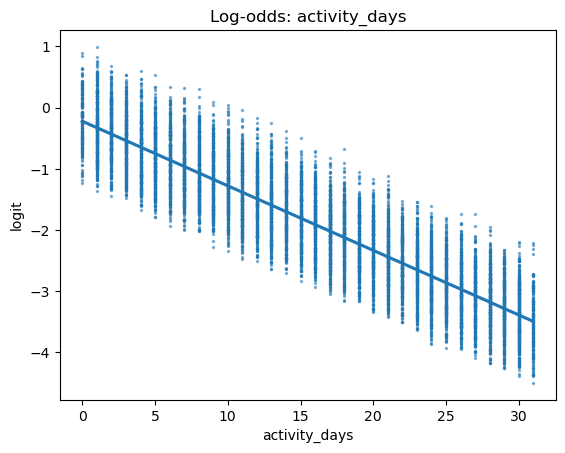

In [24]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

In [25]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [26]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

In [27]:
cm = confusion_matrix(y_test, y_preds)

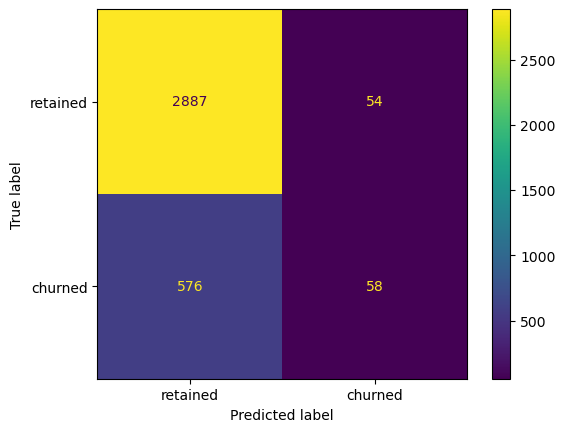

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [29]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5178571428571429

In [30]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

In [31]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



In [32]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('drives', 0.0019133543518746819),
 ('total_navigations_fav1', 0.0012317513684443593),
 ('total_navigations_fav2', 0.0009314724219668189),
 ('total_sessions', 0.00032708879707098773),
 ('duration_minutes_drives', 0.0001090940000391741),
 ('km_per_driving_day', 1.8223893890789573e-05),
 ('driven_km_drives', -1.4861267355838549e-05),
 ('n_days_after_onboarding', -0.0004064780356346654),
 ('device2', -0.0010412162362503949),
 ('professional_driver', -0.0015285023367037846),
 ('activity_days', -0.10603183692425407)]

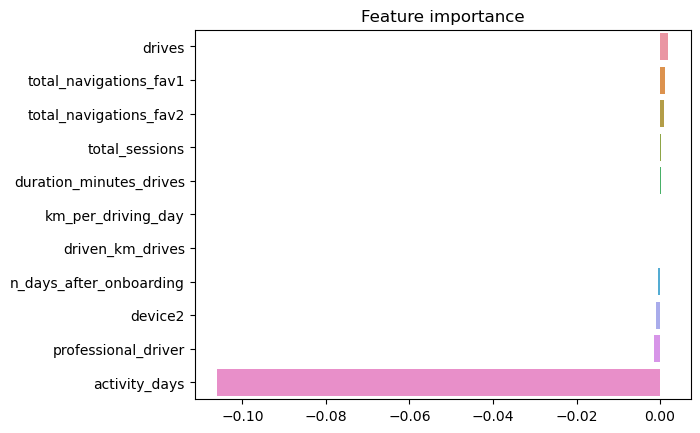

In [33]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

In [35]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 2. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.444061
std          0.278497
min          0.000000
25%          0.200241
50%          0.427865
75%          0.665012
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [36]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.330082
std          1.292477
min          0.000298
25%          0.050818
50%          0.100457
75%          0.208580
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [37]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14299.000000
mean       189.457762
std        327.519818
min         72.013095
25%         92.887853
50%        121.231277
75%        191.157779
max      21822.419685
Name: km_per_hour, dtype: float64

In [38]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.365859e+01
50%      7.429025e+01
75%      1.828194e+02
max               inf
Name: km_per_drive, dtype: float64

In [39]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14299.000000
mean       225.825460
std        572.543937
min          0.000000
25%         32.910489
50%         72.325946
75%        177.431844
max       8898.716275
Name: km_per_drive, dtype: float64

In [40]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14299.000000
mean         1.575245
std          8.243641
min          0.000000
25%          0.212409
50%          0.647726
75%          1.593733
max        668.888397
Name: percent_of_drives_to_favorite, dtype: float64

In [41]:
# Drop rows with missing values
df = df.dropna(subset=['label'])

In [43]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [44]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [45]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


#### Random Forest

In [46]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [47]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 5min 50s
Wall time: 9min 21s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'accuracy', 'f1', 'precision'})

In [48]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [49]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [50]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.452041,0.121526,0.191431,0.818277


#### XGBoost

In [51]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [52]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 2min 44s
Wall time: 3min 33s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'accuracy', 'f1', 'precision'})

In [53]:
# Examine best score
xgb_cv.best_score_

0.17280011051250171

In [54]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [55]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.452041,0.121526,0.191431,0.818277
0,XGB cv,0.416003,0.172800,0.244013,0.810234


#### Now, we'll use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

In [56]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [57]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [58]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.452041,0.121526,0.191431,0.818277
0,XGB cv,0.416003,0.172800,0.244013,0.810234
0,RF val,0.427481,0.110454,0.175549,0.816084


In [59]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.452041,0.121526,0.191431,0.818277
0,XGB cv,0.416003,0.172800,0.244013,0.810234
0,RF val,0.427481,0.110454,0.175549,0.816084
0,XGB val,0.401914,0.165680,0.234637,0.808392


In [60]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.452041,0.121526,0.191431,0.818277
0,XGB cv,0.416003,0.172800,0.244013,0.810234
0,RF val,0.427481,0.110454,0.175549,0.816084
0,XGB val,0.401914,0.165680,0.234637,0.808392
0,XGB test,0.401747,0.181460,0.250000,0.806993


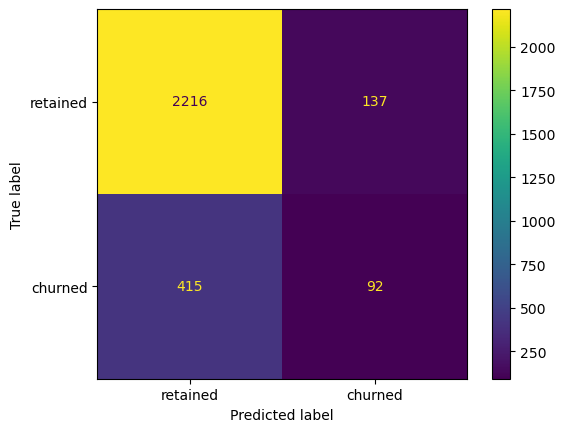

In [61]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

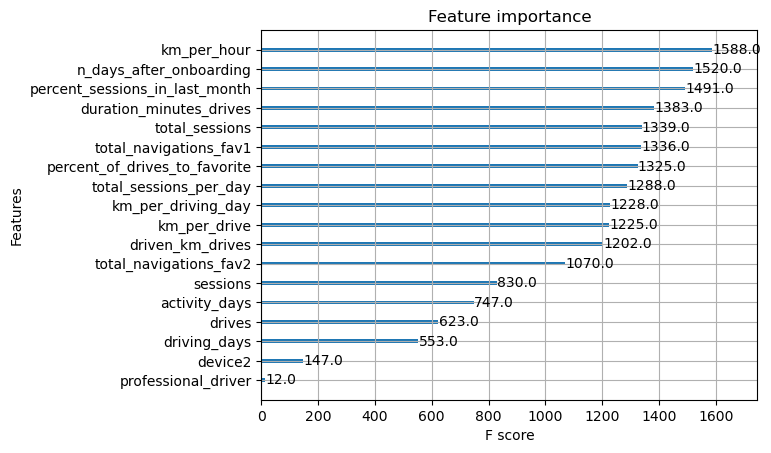

In [62]:
plot_importance(xgb_cv.best_estimator_);

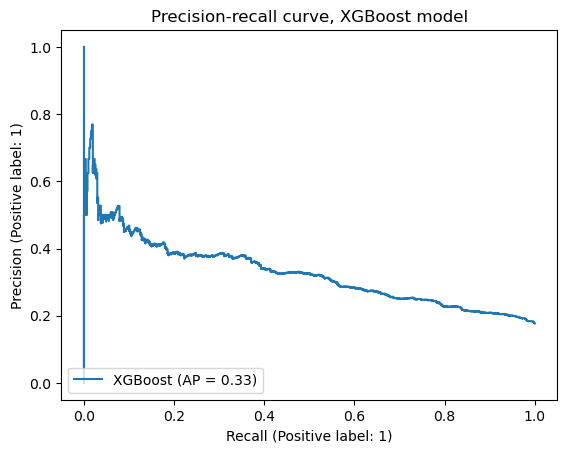

In [63]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

In [64]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.9838028 , 0.01619723],
       [0.7481251 , 0.25187492],
       [0.99610305, 0.00389696],
       ...,
       [0.8471786 , 0.15282145],
       [0.9634366 , 0.03656342],
       [0.55007076, 0.44992927]], dtype=float32)

In [65]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 1])

In [66]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.380805,0.242604,0.296386,0.795804


In [67]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.452041,0.121526,0.191431,0.818277
0,XGB cv,0.416003,0.172800,0.244013,0.810234
0,RF val,0.427481,0.110454,0.175549,0.816084
0,XGB val,0.401914,0.165680,0.234637,0.808392
0,XGB test,0.401747,0.181460,0.250000,0.806993


In [68]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


In [69]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.156, 0.5009861932938856)

In [70]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.124 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.124', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.124",0.308463,0.546351,0.394306,0.702448
